In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

In [2]:
# Isochrone reading

def isochrone_parameters():
    
    my_iso = []
    with open("Isochrone","r") as file:
      for line in file:
        my_iso.append([float(x) for x in line.split()])

    my_iso = np.asarray(my_iso)

    X = my_iso[:,5]
    Y = my_iso[:,6]

    RGB_iso = my_iso[my_iso[:,9] == 3] # Label = 3 defines RGB stars
    MS_iso = my_iso[my_iso[:,9] < 3 ] # Labels 1 and 2 define MS stars

    M_MS, log_L_MS = MS_iso[:,5], MS_iso[:,6]
    M_RGB, log_L_RGB = RGB_iso[:,5], RGB_iso[:,6]

    order_MS = np.argsort(M_MS)
    M_MS = M_MS[order_MS]
    log_L_MS = log_L_MS[order_MS]

    order_RGB = np.argsort(M_RGB)
    M_RGB = M_RGB[order_RGB]
    log_L_RGB = log_L_RGB[order_RGB]
                            
    return  M_MS, M_RGB, log_L_MS, log_L_RGB

In [3]:
# Isochrone fit: linear interpolation with Lipschitzanity condition

def rectification_parameters(x_1, x_2, y_1, y_2):
    
      ac = (y_2-y_1)/(x_2-x_1) # Angular coefficient
      q = y_1 - ac*x_1 # Intercept
    
      return ac, q

def find_your_place(mass, M_iso): # It finds the index of the nearest experimental mass value to
                                  # the selected mass value of the isochrone
    
      where = np.argmin(np.abs(M_iso-mass))

      if - (M_iso[where]-mass) > 0:
        return where
      else: 
        return where - 1

def plot_rectification(M_iso, log_L_iso, mass, _plot=False, just_extraction=False):
    
      saved_ac, _ = rectification_parameters(M_iso[0], M_iso[1],log_L_iso[0],log_L_iso[1])
      discarded_coordinates = []

      where = find_your_place(mass, M_iso)
      value_mass = 0
    
      for i in range(len(M_iso)-1):
        j = 0

        if just_extraction: # If true it just extracts the luminosity values, if false it both extracts and plots
          i = where
          saved_ac, _ = rectification_parameters(M_iso[i-1], M_iso[i], log_L_iso[i-1], log_L_iso[i])

          while True:
            ac, q = rectification_parameters(M_iso[i], M_iso[i+1+j],log_L_iso[i], log_L_iso[i+1+j])
            
            if np.abs(ac) < 3*np.abs(saved_ac): # Lipschitzanity condition
              value_mass = (mass*ac+q)
              return value_mass

            else: 
              j += 1

            if i+1+j == len(M_iso): return 0
            
        # Find the position in the rectification

        while True:
              enable_interpolation = False
    
              if where == i:
                enable_interpolation = True
              ac, q = rectification_parameters(M_iso[i], M_iso[i+1+j],log_L_iso[i], log_L_iso[i+1+j])
              
              if np.abs(ac) < 3*np.abs(saved_ac): 
                saved_ac = ac
                x_1, x_2 = M_iso[i], M_iso[i+1+j]
                y_1, y_2 = log_L_iso[i], log_L_iso[i+1+j]
                if _plot: plt.plot([x_1, x_2], [y_1, y_2], 'b+')
                x = np.linspace(x_1-0.002, x_2+0.002, 100)
                y = ac*x + q
                if _plot: plt.plot(x, y, color='red')

                if enable_interpolation:
                  if _plot: plt.plot(mass, mass*ac+q, 'g^', label='Interpolated point')
                  predicted_log_L =(mass*ac+q)
                i += j
                break
              else: 
                discarded_coordinates.append([M_iso[i+j+1], log_L_iso[i+j+1] ])
                j += 1
              if i+1+j == len(M_iso): break
      outsiders = np.asarray(discarded_coordinates)
      if _plot:
        plt.plot(outsiders[:,0], outsiders[:,1], 'b^', label='Discarded points')
        plt.xlabel(r'$M [M_\odot]$')
        plt.ylabel(r'$log(L/L_\odot)$')

      return predicted_log_L

In [4]:
# Isochrone fit: simple linear interpolation

def linear_interpolation(M_iso, log_L_iso, mass, _plot=False):
    
  where = find_your_place(mass, M_iso)

  predicted_log_L = log_L_iso[where]+(log_L_iso[where+1]-log_L_iso[where])/ \
                    (M_iso[where+1]-M_iso[where])*(mass-M_iso[where])

 # It plots the value of log_L associated to the linear interpolation of two consecutive mass values
  
  if _plot:
    plt.plot([M_iso[where], M_iso[where+1]], [log_L_iso[where], log_L_iso[where+1]], color='red')
    plt.plot(mass, predicted_log_L, 'b^')
    plt.xlabel(r'$M [M_\odot]$')
    plt.ylabel(r'$log(L/L_\odot)$')
    plt.legend()

  return predicted_log_L

In [5]:
# MS polynomial fit

def interpolate_MS(X, Y, _plot=False):
  degree = 10
  p = np.polyfit(X, Y, deg=degree)
    
  if _plot: plt.plot(X, Y, 'm*', label='MS data')

  x_min = np.min(X)
  x_max = np.max(X)  
  x_values = np.linspace(x_min, x_max, 1000)
  y_values =[x_values**i for i in range(degree+1)]
  y_values = np.asarray(y_values)
  func = np.dot(y_values.T,p[::-1])
    
  if _plot:
    plt.plot(x_values, func, label='%i th-order log fit'%degree, color='pink')
    plt.xlabel(r'$M [M_\odot]$')
    plt.ylabel(r'$log(L/L_\odot)$')
    plt.legend()
    
  return p[::-1]

In [6]:
# RGB polynomial fit

def interpolate_RGB(X, Y, _plot=False):
  degree = 5
  p = np.polyfit(X, np.exp(Y), deg=degree)
    
  if _plot: plt.plot(X, Y, 'c*', label='RGB data')
    
  x_min = np.min(X)
  x_max = np.max(X)
  x_values = np.linspace(x_min, x_max, 1000)
  y_values =[x_values**i for i in range(degree+1)]
  y_values = np.asarray(y_values)
  func = np.log(np.dot(y_values.T,p[::-1]))
    
  if _plot:
    plt.plot(x_values, func, label='%i th-order log fit'%degree, color='yellow')
    plt.xlabel(r'$M [M_\odot]$')
    plt.ylabel(r'$log(L/L_\odot)$')
    plt.legend()
    
  return p[::-1]

In [7]:
def luminosity_RGB(M_RGB, log_L_RGB, mass):
    
    if mass < 0.785:
        pred_log_L_RGB = linear_interpolation(M_RGB, log_L_RGB, mass)
    else:
        where = find_your_place(mass, M_RGB)
        pred_log_L_RGB = log_L_RGB[where]

    L_RGB = 10**(pred_log_L_RGB)  

    return L_RGB


def luminosity_MS(M_MS, log_L_MS, mass):
    
    pred_log_L_MS = linear_interpolation(M_MS, log_L_MS, mass)
    L_MS = 10**(pred_log_L_MS) 
    
    return L_MS

/var/folders/zz/3gvwdv9x1h5bwb0qlw_1qznr0000gp/T/ipykernel_1832/3934859894.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  ac = (y_2-y_1)/(x_2-x_1) # Angular coefficient


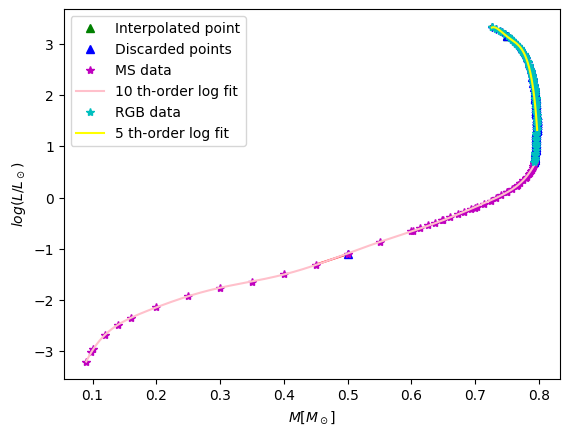

In [8]:
M_MS, M_RGB, log_L_MS, log_L_RGB = isochrone_parameters()

log_luminosity_RGB = plot_rectification(M_RGB, log_L_RGB, 0.75, _plot=True, just_extraction=False)

predicted_log_L_MS = linear_interpolation(M_MS, log_L_MS, 0.5, True)

predicted_log_L_RGB = linear_interpolation(M_RGB, log_L_RGB, 0.75, True)

param_MS = interpolate_MS(M_MS, log_L_MS, True)

param_RGB = interpolate_RGB(M_RGB, log_L_RGB, True)